# Library

In [ ]:
import numpy as np
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.datasets import cifar100
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Load Data

In [ ]:
(train_images,train_labels),(test_images,test_labels) = cifar100.load_data()

# Categories 
### 3=bear 22=clock 50=mouse 58=pickup_truck 61=plate 71=sea 90=train 

In [ ]:
selected_classes = [3, 22, 50, 58, 61, 71, 90]

train_images_filtered, train_labels_filtered = [], []
test_images_filtered, test_labels_filtered = [], []

for i in range(len(train_labels)):
    if train_labels[i][0] in selected_classes:
        train_images_filtered.append(train_images[i])
        train_labels_filtered.append(train_labels[i][0])

for i in range(len(test_labels)):
    if test_labels[i][0] in selected_classes:
        test_images_filtered.append(test_images[i])
        test_labels_filtered.append(test_labels[i][0])

train_images_filtered = np.array(train_images_filtered)
train_labels_filtered = np.array(train_labels_filtered)
test_images_filtered = np.array(test_images_filtered)
test_labels_filtered = np.array(test_labels_filtered)

print("Filtrelenmis egitim veri seti boyutu:", train_images_filtered.shape)
print("Filtrelenmis test veri seti boyutu:", test_images_filtered.shape)

Filtrelenmis egitim veri seti boyutu: (3500, 32, 32, 3)
Filtrelenmis test veri seti boyutu: (700, 32, 32, 3)


# Visualization

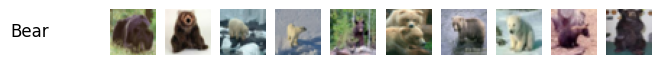

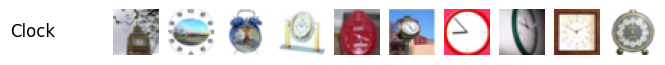

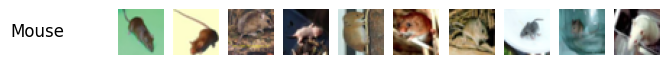

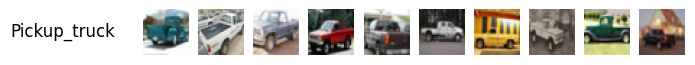

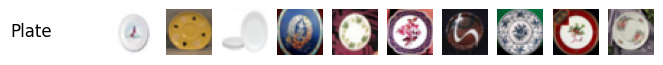

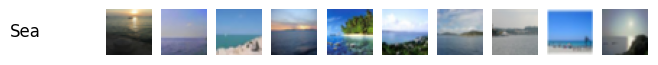

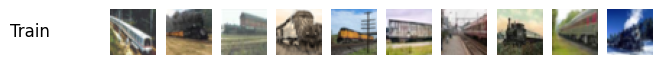

In [ ]:
categories = ["Bear","Clock","Mouse","Pickup_truck","Plate","Sea","Train"]
selected_classes = [3, 22, 50, 58, 61, 71, 90]
def show(classes, images, labels, categories, num_images=10):
    for i in range(len(classes)):
        category_images = [images[j] for j in range(len(labels)) if labels[j] == classes[i]]


        fig,axes = plt.subplots(1, num_images, figsize=(7, 2))
        fig.text(0.01, 0.5, categories[i], ha='center', va='center', fontsize=12)

        for k in range(min(num_images, len(category_images))): #secilen 10dan az olabilir bu yuzden min alinir.
            axes[k].imshow(category_images[k])
            axes[k].axis('off')
        plt.show()

show(selected_classes, train_images_filtered, train_labels_filtered, categories)

# Data Augmentation

In [ ]:
datagen =tf.keras.preprocessing.image.ImageDataGenerator(
                                rotation_range=90,
                                brightness_range=[0.4,1.5],
                                width_shift_range=0.10,
                                height_shift_range=0.10,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                               fill_mode='nearest'
)


In [ ]:
augmented_data = datagen.flow(train_images_filtered,train_labels_filtered,batch_size=350)

In [ ]:
train_images_augmented = train_images_filtered.copy()
train_labels_augmented = train_labels_filtered.copy()

for i in range(10):
  images, labels = next(augmented_data)
  train_images_augmented = np.concatenate([train_images_augmented, images])
  train_labels_augmented = np.concatenate([train_labels_augmented, labels])

In [ ]:
train_images_augmented.shape

(7000, 32, 32, 3)

# Data Preprocessing

In [ ]:
label_mapping = {3: 0, 22: 1, 50: 2, 58: 3, 61: 4, 71: 5, 90: 6}

train_labels_augmented = np.array([label_mapping[label] for label in train_labels_augmented])
test_labels_filtered = np.array([label_mapping[label] for label in test_labels_filtered])

In [ ]:
train_images_augmented = train_images_augmented.reshape((7000,32,32,3))
train_images_augmented = train_images_augmented.astype('float32') /255

test_images_filtered = test_images_filtered.reshape((700,32,32,3))
test_images_filtered = test_images_filtered.astype('float32') /255



train_labels_augmented = to_categorical(train_labels_augmented)
test_labels_filtered = to_categorical(test_labels_filtered)

# Model 

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(
    64,
    (3,3),
    padding='same',
    input_shape=(32,32,3),
    activation='relu'
))
model.add(layers.Conv2D(
    64,
    (3,3),
    padding='same',
    activation='relu'
))

model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(
    128,
    (3,3),
    padding='same',
    activation='relu'
))
model.add(layers.Conv2D(
    128,
    (3,3),
    padding='same',
    activation='relu'
))

model.add(layers.MaxPool2D((2,2)))



model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7,activation='softmax'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_108 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_109 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_110 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 conv2d_111 (Conv2D)         (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_55 (MaxPooli  (None, 8, 8, 128)         0         
 ng2D)                                               

# Block Schema

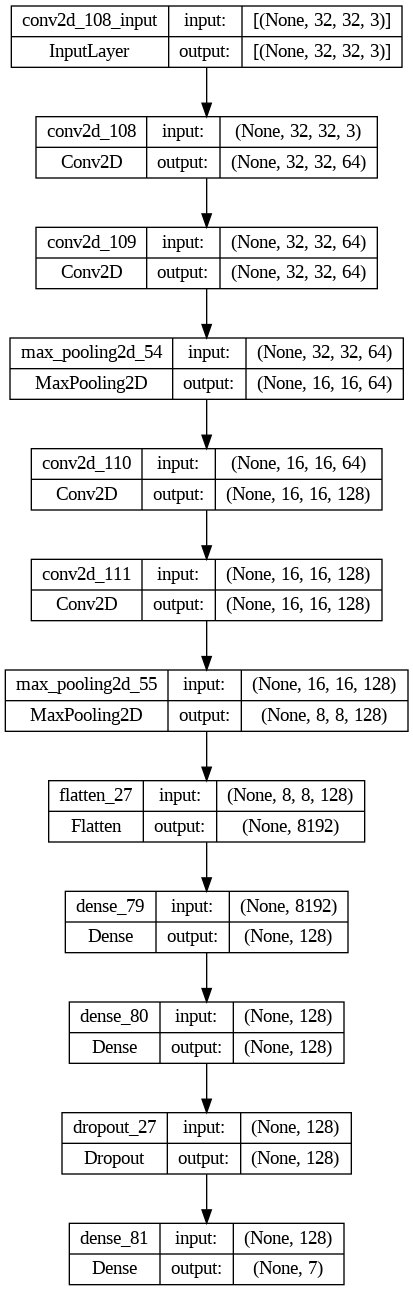

In [ ]:
import keras
keras.utils.plot_model(model,"model.png",show_shapes=True)

# Model Compile

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            mode='min',
                                            patience = 3,
                                            verbose=1,
                                            restore_best_weights = True)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC','Recall']
)

# Model Fit

In [ ]:
history = model.fit(train_images_augmented
                    ,train_labels_augmented
                    ,batch_size=256,
                    epochs=200,
                    validation_data=(test_images_filtered,test_labels_filtered),
                    callbacks=[early_stop]
                )

Epoch 1/200
28/28 [==============================] - 4s 54ms/step - loss: 1.8571 - accuracy: 0.2296 - auc: 0.6313 - recall: 0.0061 - val_loss: 1.6838 - val_accuracy: 0.3343 - val_auc: 0.7356 - val_recall: 0.0529
Epoch 2/200
28/28 [==============================] - 1s 37ms/step - loss: 1.6018 - accuracy: 0.3719 - auc: 0.7620 - recall: 0.1037 - val_loss: 1.3568 - val_accuracy: 0.5086 - val_auc: 0.8480 - val_recall: 0.1900
Epoch 3/200
28/28 [==============================] - 1s 36ms/step - loss: 1.4034 - accuracy: 0.4616 - auc: 0.8290 - recall: 0.2086 - val_loss: 1.2282 - val_accuracy: 0.5271 - val_auc: 0.8784 - val_recall: 0.2543
Epoch 4/200
28/28 [==============================] - 1s 36ms/step - loss: 1.2729 - accuracy: 0.5194 - auc: 0.8623 - recall: 0.2950 - val_loss: 1.1156 - val_accuracy: 0.6043 - val_auc: 0.8980 - val_recall: 0.3957
Epoch 5/200
28/28 [==============================] - 1s 37ms/step - loss: 1.1537 - accuracy: 0.5701 - auc: 0.8885 - recall: 0.3724 - val_loss: 0.9700 - 

In [178]:
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Loss Val Loss Graph

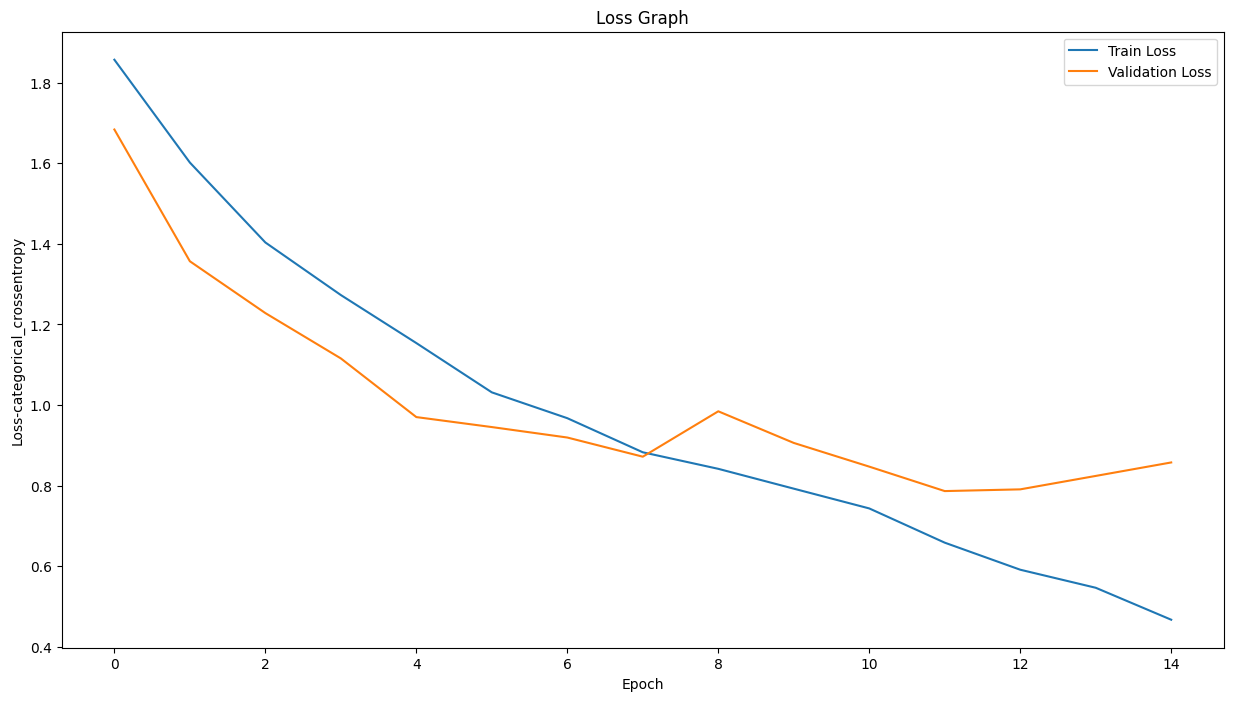

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'],label ='Train Loss')
plt.plot(history.history['val_loss'],label ='Validation Loss')
plt.ylabel('Loss-categorical_crossentropy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Loss Graph')
plt.show()

# Accuracy Val Accuracy Graph

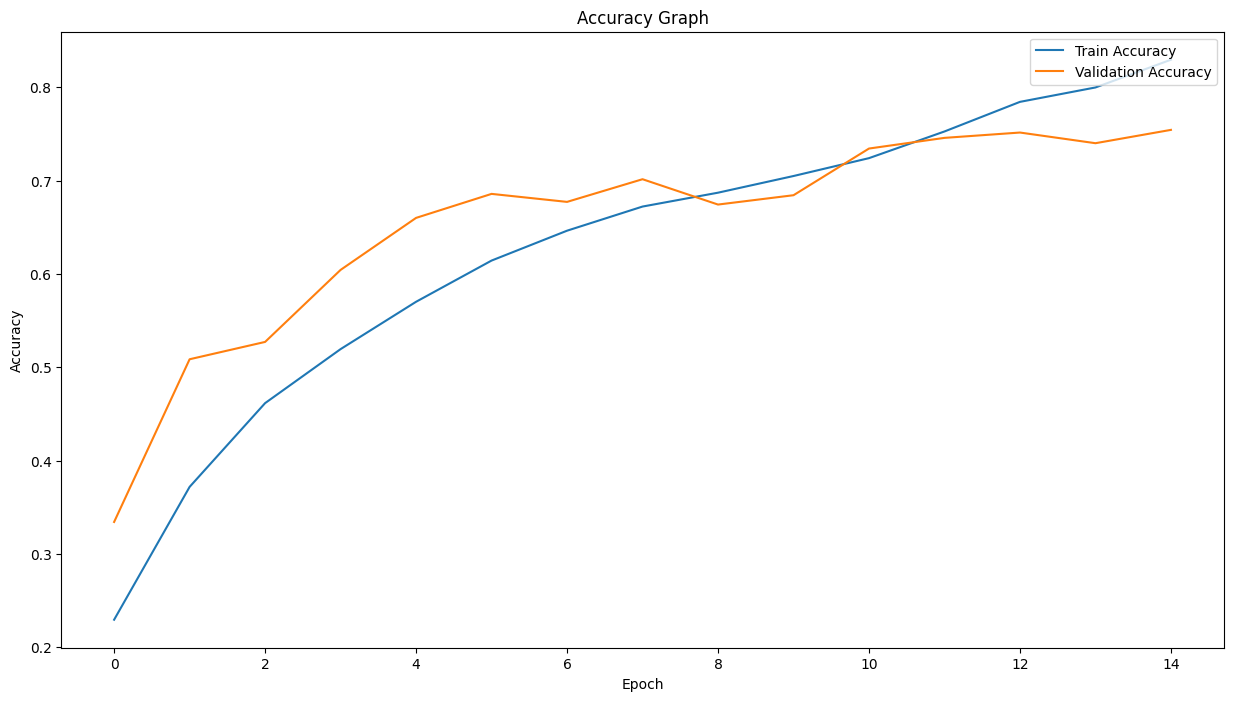

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Accuracy Graph')
plt.show()

# Model Evaluate

In [ ]:
test_loss,test_acc,test_auc,test_recall = model.evaluate(test_images_filtered,test_labels_filtered)
print("Test loss: ",test_loss)
print("Test acc: ",test_acc)
print("Test auc: ",test_auc)
print("Test recall: ",test_recall)

22/22 [==============================] - 0s 6ms/step - loss: 0.7863 - accuracy: 0.7457 - auc: 0.9499 - recall: 0.6943
Test loss:  0.7863251566886902
Test acc:  0.7457143068313599
Test auc:  0.9498769640922546
Test recall:  0.6942856907844543


# Confusion Matrix

22/22 [==============================] - 0s 3ms/step


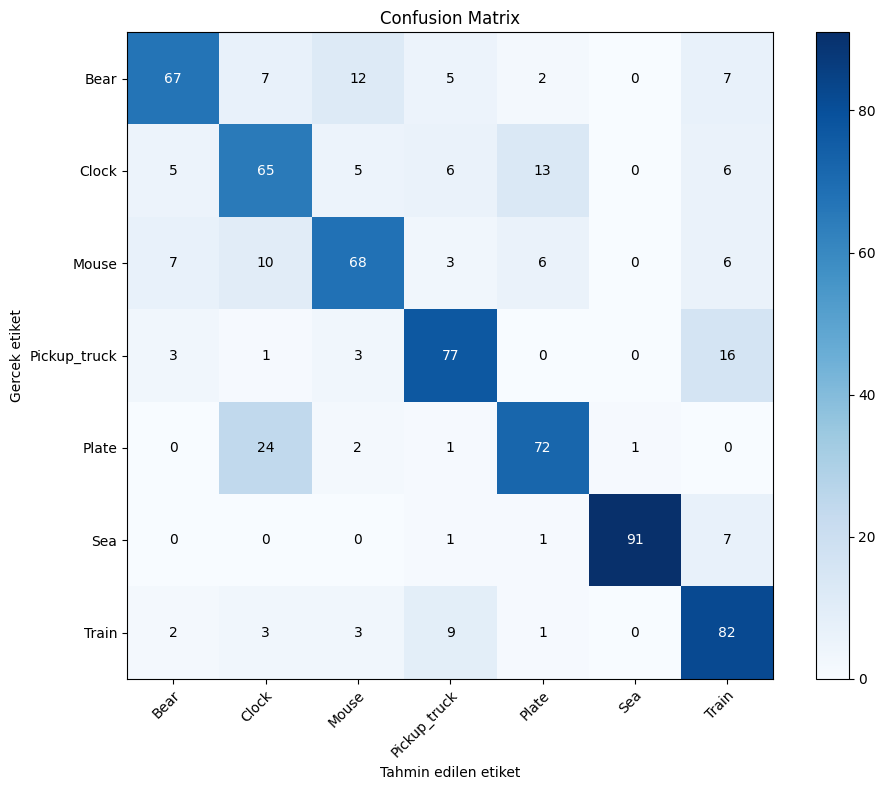

In [ ]:
predictions = model.predict(test_images_filtered)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels_filtered, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)

class_labels = ["Bear","Clock","Mouse","Pickup_truck","Plate","Sea","Train"]

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_labels, yticklabels=class_labels,
       title='Confusion Matrix',
       ylabel='Gercek etiket',
       xlabel='Tahmin edilen etiket')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlim(-0.5, len(np.unique(class_labels))-0.5)
ax.set_ylim(len(np.unique(class_labels))-0.5, -0.5)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.tight_layout()
plt.show()

# Model Test

In [ ]:
map_list = {0:'Bear',1:'Clock',2:'Mouse',3:'Pickup Truck',4:'Plate',5:'Sea',6:'Train'}
def testModel(test_images_filtered,test_labels_filtered):
    rand = np.random.randint(0, len(test_images_filtered) - 1)
    test = test_images_filtered[rand]
    plt.imshow(test)
    test = test.reshape(1,32,32,3)
    tahmin = model.predict(test)
    sonuc = np.argmax(tahmin)
    print("Vektor: ",tahmin)
    print("Tahmin sonucu: ",map_list[sonuc])

    gercek = test_labels_filtered[rand]
    gercek = np.argmax(gercek)
    print("Gercek sonuc: ",map_list[gercek])


1/1 [==============================] - 0s 18ms/step
Vektor:  [[1.9234882e-05 8.3243139e-03 6.7555825e-06 9.8529053e-01 2.4228402e-04
  1.2558074e-06 6.1154654e-03]]
Tahmin sonucu:  Pickup Truck
Gercek sonuc:  Pickup Truck


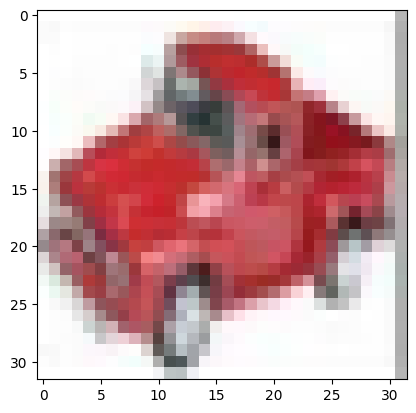

In [209]:
testModel(test_images_filtered,test_labels_filtered)